In [1]:
!pip install mlxtend
!pip install lightgbm
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
%matplotlib inline
start_time = dt.datetime.now()

In [2]:
# set some parameters
num_files = 1
# set num_filter to be about 10 to 20% of the original # variables
num_filter = 350
num_wrapper = 25
balance = 0
detect_rate = .03
index_name = 'record'
y_name = 'fraud_label'
good_label = 0
bad_label = 1

## Run a filter on all the files

In [3]:
%%time
filter_score_df_list = []
for i in range(num_files):
#     file_name = "vars"+str(i+1)+'.csv'
    file_name = 'vars.csv'
    df = pd.read_csv(file_name)
    print("********** working on",file_name,"size is",df.shape)
    df = df.set_index(index_name) 
    df = df[df.index <= 833507] # remove the last two months as the out-of-time data (OOT)
    df = df[df.index >= 38511] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods = goods.loc[goods_keep] 
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.sort_index(inplace=True)
    filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
    filter_score.columns = ['variable','filter score']   
    j = 0
    for column in df_sampled:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'filter score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)

    filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_filter+1]) 
    print(file_name,filter_score.head(20))
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)

    filter_score_df_list.append(filter_score)
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()
filter_score = pd.concat(filter_score_df_list)

********** working on vars.csv size is (1000000, 2242)
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
vars.csv                                             variable  filter score
0                                        fraud_label      1.000000
2128                     max_count_by_fulladdress_30      0.359914
2108                         max_count_by_address_30      0.359215
2107                          max_count_by_address_7      0.343335
2127                      max_count_by_fulladdress_7      0.343052
10                                 address_day_since      0.334140
45                             fulladdress_day_since      0.333269
16                                  address_count_30      0.332648
51                              fulladdress_count_30      0.331969
2126                      max_count_by_fulladdress_3      0.329538
2106                          max_count_by_address_3      0.329445
15                             

In [4]:
filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
filter_score.reset_index(drop=True,inplace=True)

In [5]:
filter_score.head(30)

,variable,filter score
0,fraud_label,1.000000
1,max_count_by_fulladdress_30,0.359914
2,max_count_by_address_30,0.359215
3,max_count_by_address_7,0.343335
4,max_count_by_fulladdress_7,0.343052
5,address_day_since,0.334140
6,fulladdress_day_since,0.333269
7,address_count_30,0.332648
8,fulladdress_count_30,0.331969
9,max_count_by_fulladdress_3,0.329538


In [6]:
filter_score.tail(10)

,variable,filter score
2232,ssn_fulladdress_unique_count_for_ssn_lastname_3,0.000004
2233,ssn_zip5_unique_count_for_name_fulladdress_30,0.000003
2234,homephone_name_dob_unique_count_for_zip5_0,0.000003
2235,ssn_zip5_unique_count_for_ssn_lastname_1,0.000003
2236,ssn_dob_unique_count_for_ssn_firstname_0,0.000003
2237,ssn_zip5_unique_count_for_address_14,0.000002
2238,ssn_lastname_unique_count_for_name_0,0.000001
2239,name_fulladdress_unique_count_for_zip5_30,0.000001
2240,ssn_fulladdress_unique_count_for_ssn_firstname_60,0.000001
2241,fulladdress_unique_count_for_address_0,0.000000


In [7]:
filter_score.shape

(2242, 2)

In [8]:
filter_score.head(80).to_csv('filter_top.csv')
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(i,' vars_keep:',vars_keep)

0  vars_keep: ['max_count_by_fulladdress_30', 'max_count_by_address_30', 'max_count_by_address_7', 'max_count_by_fulladdress_7', 'address_day_since', 'fulladdress_day_since', 'address_count_30', 'fulladdress_count_30', 'max_count_by_fulladdress_3', 'max_count_by_address_3', 'address_count_14', 'fulladdress_count_14', 'max_count_by_address_1', 'max_count_by_fulladdress_1', 'address_count_7', 'fulladdress_count_7', 'address_unique_count_for_name_homephone_60', 'address_count_0_by_30', 'address_unique_count_for_homephone_name_dob_60', 'fulladdress_count_0_by_30', 'fulladdress_unique_count_for_ssn_homephone_60', 'address_unique_count_for_ssn_zip5_60', 'address_unique_count_for_ssn_name_60', 'fulladdress_unique_count_for_name_homephone_60', 'address_unique_count_for_ssn_homephone_60', 'fulladdress_unique_count_for_homephone_name_dob_60', 'fulladdress_unique_count_for_dob_homephone_60', 'address_unique_count_for_ssn_firstname_60', 'address_unique_count_for_ssn_name_dob_60', 'address_unique_c

In [9]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,max_count_by_fulladdress_30,max_count_by_address_30,max_count_by_address_7,max_count_by_fulladdress_7,address_day_since,fulladdress_day_since,address_count_30,fulladdress_count_30,max_count_by_fulladdress_3,max_count_by_address_3,...,ssn_name_count_7,ssn_name_count_0_by_14,zip5_day_since,homephone_unique_count_for_ssn_zip5_3,homephone_unique_count_for_ssn_address_3,homephone_unique_count_for_ssn_fulladdress_3,homephone_unique_count_for_ssn_dob_3,homephone_unique_count_for_fulladdress_dob_3,homephone_unique_count_for_ssn_name_dob_3,homephone_unique_count_for_ssn_3
record,,,,,,,,,,,,,,,,,,,,,
38511.0,14.0,14.0,10.0,10.0,0.0,0.0,12.0,12.0,6.0,6.0,...,1.0,14.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
38512.0,1.0,1.0,1.0,1.0,365.0,365.0,1.0,1.0,1.0,1.0,...,1.0,14.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
38513.0,1.0,1.0,1.0,1.0,365.0,365.0,1.0,1.0,1.0,1.0,...,1.0,14.0,4.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
38514.0,1.0,1.0,1.0,1.0,365.0,365.0,1.0,1.0,1.0,1.0,...,1.0,14.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
38515.0,1.0,1.0,1.0,1.0,365.0,365.0,1.0,1.0,1.0,1.0,...,1.0,14.0,10.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [10]:
df_keep.shape

(794997, 350)

In [11]:
Y.head()

,fraud_label
record,
38511.0,1.0
38512.0,0.0
38513.0,0.0
38514.0,0.0
38515.0,0.0


In [12]:
Y = Y.values
Y_save = Y.copy()

In [13]:
# Y = np.array(Y)
X = df_keep
print(Y)

[[1.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [14]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:39:47.454313


In [15]:
print(X.shape,Y.shape)

(794997, 350) (794997, 1)


In [16]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [17]:
# I'd like to define a scoring for the wrapper that's KS, but I haven't gotten around to this yet.
# def KSscore(classifier, x,y)
#     goods = 

In [18]:
def fdr(classifier, x, y, cutoff=detect_rate):
# Calculates FDR score for the given classifier on dataset x and y with cutoff value
# get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)
def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:    # sometimes the proba list can contain many columns, one for each category
        y_prob = y_prob[:, -1:]   # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])    # count the total nunber of frauds   
# sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
# return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud   

## Run a wrapper on the remaining top variables

In [19]:
%%time
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

nfeatures = len(X.columns)
# clf = RandomForestClassifier(n_estimators=5)
clf = LGBMClassifier(n_estimators=20,num_leaves=3) 
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=0,scoring=fdr,cv=3,n_jobs=-1) # use for forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=0,scoring=fdr,cv=3,n_jobs=-1) # use for backward selection
sfs.fit(X,Y)

Wall time: 3h 3min 56s


SequentialFeatureSelector(cv=3,
                          estimator=LGBMClassifier(n_estimators=20,
                                                   num_leaves=3),
                          k_features=(25, 25), n_jobs=-1,
                          scoring=<function fdr at 0x000001AE450DB8B0>)

In [20]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 3:43:44.250473


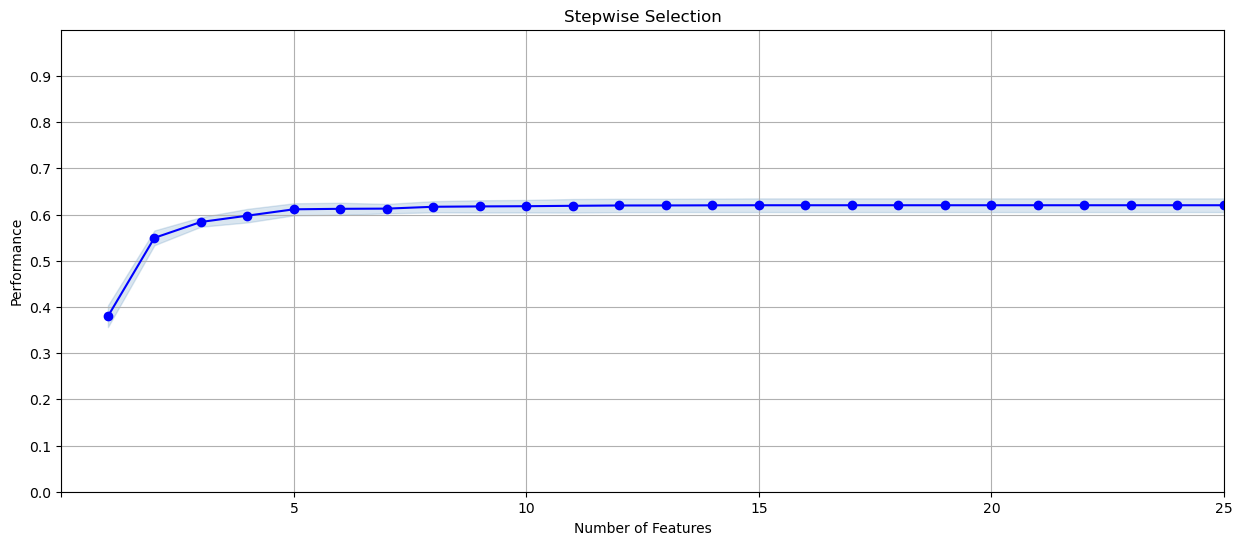

In [21]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([0., 1])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('performance_nvars.png')
plt.show()

In [22]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [23]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(ordered_vars_FS.loc[i+1,'feature_names'])[0])
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])))
        ordered_vars_FS.loc[i+1,'variable name'] = ordered_vars_FS.loc[i+1,'variable name'][0]

In [24]:
ordered_vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(1,)","[0.35361713241055104, 0.41028989292243406, 0.3...",0.379647,"(max_count_by_address_30,)",0.05258,0.023365,0.016522,1.0,max_count_by_address_30
2,"(1, 205)","[0.5270305562810134, 0.5620266388090885, 0.559...",0.549491,"(max_count_by_address_30, max_count_by_ssn_dob_7)",0.03582,0.015917,0.011255,2.0,[max_count_by_ssn_dob_7]
3,"(1, 205, 225)","[0.5701227474536432, 0.5949334029772787, 0.586...",0.583877,"(max_count_by_address_30, max_count_by_ssn_dob...",0.023194,0.010307,0.007288,3.0,[max_count_by_homephone_3]
4,"(1, 205, 225, 244)","[0.5769130321232698, 0.6087751371115173, 0.606...",0.597545,"(max_count_by_address_30, max_count_by_ssn_dob...",0.032873,0.014608,0.010329,4.0,[zip5_count_1]
5,"(0, 1, 205, 225, 244)","[0.5931052494123792, 0.6228780360407417, 0.617...",0.6113,"(max_count_by_fulladdress_30, max_count_by_add...",0.029308,0.013024,0.009209,5.0,[max_count_by_fulladdress_30]
6,"(0, 1, 205, 225, 227, 244)","[0.5938887437973361, 0.6228780360407417, 0.620...",0.612344,"(max_count_by_fulladdress_30, max_count_by_add...",0.029465,0.013094,0.009259,6.0,[max_count_by_name_30]
7,"(0, 1, 199, 205, 225, 227, 244)","[0.5983285453120919, 0.6202663880908853, 0.619...",0.61278,"(max_count_by_fulladdress_30, max_count_by_add...",0.023,0.010221,0.007227,7.0,[max_count_by_homephone_7]
8,"(0, 1, 192, 199, 205, 225, 227, 244)","[0.6001566988769914, 0.6286236615304257, 0.621...",0.616784,"(max_count_by_fulladdress_30, max_count_by_add...",0.02724,0.012105,0.008559,8.0,[max_count_by_ssn_dob_30]
9,"(0, 1, 19, 192, 199, 205, 225, 227, 244)","[0.5993732044920345, 0.6307129798903108, 0.622...",0.617568,"(max_count_by_fulladdress_30, max_count_by_add...",0.029892,0.013283,0.009393,9.0,[fulladdress_count_0_by_30]
10,"(0, 1, 19, 192, 199, 205, 217, 225, 227, 244)","[0.5993732044920345, 0.6314964742752677, 0.623...",0.618003,"(max_count_by_fulladdress_30, max_count_by_add...",0.030622,0.013608,0.009622,10.0,[ssn_firstname_day_since]


In [25]:
ordered_vars_FS.to_csv('Wrapper_selection_info.csv', index=False)

In [26]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list.csv',index=False)
vars_keep

1                     max_count_by_address_30
2                    [max_count_by_ssn_dob_7]
3                  [max_count_by_homephone_3]
4                              [zip5_count_1]
5               [max_count_by_fulladdress_30]
6                      [max_count_by_name_30]
7                  [max_count_by_homephone_7]
8                   [max_count_by_ssn_dob_30]
9                 [fulladdress_count_0_by_30]
10                  [ssn_firstname_day_since]
11                [max_count_by_homephone_30]
12                    [fulladdress_day_since]
13     [address_unique_count_for_ssn_zip5_60]
14    [max_count_by_fulladdress_homephone_30]
15                         [address_count_30]
16                   [max_count_by_address_7]
17                        [address_day_since]
18               [max_count_by_fulladdress_3]
19                   [max_count_by_address_3]
20                         [address_count_14]
21                     [fulladdress_count_14]
22                   [max_count_by

In [27]:
true_vars_keep_list=[]

for i in vars_keep:
    if type(i)==list:
        temp=i[0]
        true_vars_keep_list.append(temp)
    else:
        true_vars_keep_list.append(i)
true_vars_keep_list

['max_count_by_address_30',
 'max_count_by_ssn_dob_7',
 'max_count_by_homephone_3',
 'zip5_count_1',
 'max_count_by_fulladdress_30',
 'max_count_by_name_30',
 'max_count_by_homephone_7',
 'max_count_by_ssn_dob_30',
 'fulladdress_count_0_by_30',
 'ssn_firstname_day_since',
 'max_count_by_homephone_30',
 'fulladdress_day_since',
 'address_unique_count_for_ssn_zip5_60',
 'max_count_by_fulladdress_homephone_30',
 'address_count_30',
 'max_count_by_address_7',
 'address_day_since',
 'max_count_by_fulladdress_3',
 'max_count_by_address_3',
 'address_count_14',
 'fulladdress_count_14',
 'max_count_by_address_1',
 'max_count_by_fulladdress_1',
 'address_count_7',
 'fulladdress_count_7']

In [28]:
filter_score.set_index('variable',drop=True,inplace=True)
filter_score = filter_score.iloc[1:,:]
filter_score

,filter score
variable,
max_count_by_fulladdress_30,0.359914
max_count_by_address_30,0.359215
max_count_by_address_7,0.343335
max_count_by_fulladdress_7,0.343052
address_day_since,0.334140
...,...
ssn_zip5_unique_count_for_address_14,0.000002
ssn_lastname_unique_count_for_name_0,0.000001
name_fulladdress_unique_count_for_zip5_30,0.000001


In [29]:
vars_keep_sorted = pd.DataFrame(vars_keep_list)
vars_keep_sorted.columns=['variable']
vars_keep_sorted.set_index('variable',drop=True,inplace=True)
vars_keep_sorted.head()

""
variable
max_count_by_address_30
[max_count_by_ssn_dob_7]
[max_count_by_homephone_3]
[zip5_count_1]
[max_count_by_fulladdress_30]


In [30]:
vars_keep_sorted = pd.DataFrame(true_vars_keep_list)
vars_keep_sorted.columns=['variable']
vars_keep_sorted.set_index('variable',drop=True,inplace=True)
vars_keep_sorted.head()

""
variable
max_count_by_address_30
max_count_by_ssn_dob_7
max_count_by_homephone_3
zip5_count_1
max_count_by_fulladdress_30


In [31]:
vars_keep_sorted = pd.concat([vars_keep_sorted,filter_score],axis=1,join='inner')
vars_keep_sorted

,filter score
variable,
max_count_by_address_30,0.359215
max_count_by_ssn_dob_7,0.228401
max_count_by_homephone_3,0.224757
zip5_count_1,0.221239
max_count_by_fulladdress_30,0.359914
max_count_by_name_30,0.222191
max_count_by_homephone_7,0.232235
max_count_by_ssn_dob_30,0.240836
fulladdress_count_0_by_30,0.290722


In [32]:
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted['index'] = vars_keep_sorted['index'] + 1
vars_keep_sorted.rename(columns={'index':'wrapper order'},inplace=True)
vars_keep_sorted.to_csv('vars_keep_sorted.csv',index=False)
vars_keep_sorted

,wrapper order,variable,filter score
0,1,max_count_by_address_30,0.359215
1,2,max_count_by_ssn_dob_7,0.228401
2,3,max_count_by_homephone_3,0.224757
3,4,zip5_count_1,0.221239
4,5,max_count_by_fulladdress_30,0.359914
5,6,max_count_by_name_30,0.222191
6,7,max_count_by_homephone_7,0.232235
7,8,max_count_by_ssn_dob_30,0.240836
8,9,fulladdress_count_0_by_30,0.290722
9,10,ssn_firstname_day_since,0.226428


In [33]:
true_vars_keep_list.append(index_name)
true_vars_keep_list.append(y_name)
true_vars_keep_list

['max_count_by_address_30',
 'max_count_by_ssn_dob_7',
 'max_count_by_homephone_3',
 'zip5_count_1',
 'max_count_by_fulladdress_30',
 'max_count_by_name_30',
 'max_count_by_homephone_7',
 'max_count_by_ssn_dob_30',
 'fulladdress_count_0_by_30',
 'ssn_firstname_day_since',
 'max_count_by_homephone_30',
 'fulladdress_day_since',
 'address_unique_count_for_ssn_zip5_60',
 'max_count_by_fulladdress_homephone_30',
 'address_count_30',
 'max_count_by_address_7',
 'address_day_since',
 'max_count_by_fulladdress_3',
 'max_count_by_address_3',
 'address_count_14',
 'fulladdress_count_14',
 'max_count_by_address_1',
 'max_count_by_fulladdress_1',
 'address_count_7',
 'fulladdress_count_7',
 'record',
 'fraud_label']

In [34]:
filter_score

,filter score
variable,
max_count_by_fulladdress_30,0.359914
max_count_by_address_30,0.359215
max_count_by_address_7,0.343335
max_count_by_fulladdress_7,0.343052
address_day_since,0.334140
...,...
ssn_zip5_unique_count_for_address_14,0.000002
ssn_lastname_unique_count_for_name_0,0.000001
name_fulladdress_unique_count_for_zip5_30,0.000001


In [35]:
%%time
df = pd.read_csv(file_name)
df.shape

Wall time: 1h 9min 12s


(1000000, 2242)

In [36]:
df_keep = df.filter(true_vars_keep_list, axis=1)
# df_keep = df[df.index.isin(vars_keep_list)]
print(df_keep.shape)

(1000000, 27)


In [37]:
df_keep.to_csv('vars_final.csv',index=False)

In [38]:
print("duration: ", dt.datetime.now() - start_time)

duration:  4:53:09.247877
